# Mahalanobis outlier detection on KDD Cup '99 dataset

The outlier detector needs to detect computer network intrusions using TCP dump data for a local-area network (LAN) simulating a typical U.S. Air Force LAN. A connection is a sequence of TCP packets starting and ending at some well defined times, between which data flows to and from a source IP address to a target IP address under some well defined protocol. Each connection is labeled as either normal, or as an attack.

There are 4 types of attacks in the dataset:

- DOS: denial-of-service, e.g. syn flood;
- R2L: unauthorized access from a remote machine, e.g. guessing password;
- U2R: unauthorized access to local superuser (root) privileges;
- probing: surveillance and other probing, e.g., port scanning.

The dataset contains about 5 million connection records.

There are 3 types of features:

- basic features of individual connections, e.g. duration of connection
- content features within a connection, e.g. number of failed log in attempts
- traffic features within a 2 second window, e.g. number of connections to the same host as the current connection

In [1]:
import sys
sys.path.append('..')
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

from odcd.od.mahalanobis import Mahalanobis
from odcd.datasets import fetch_kdd
from odcd.utils.data import create_outlier_batch
from odcd.utils.visualize import plot_outlier_scores

## Load dataset

We only keep the continuous (18 out of 41) features.

In [2]:
kddcup = fetch_kdd(percent10=True)  # only load 10% of the dataset
print(kddcup.data.shape, kddcup.target.shape)

(494021, 18) (494021,)


Assume that a model is trained on *normal* instances of the dataset (not outliers) and standardization is applied:

In [3]:
normal_batch = create_outlier_batch(kddcup.data, kddcup.target, n_samples=10000, perc_outlier=0)
data, target = normal_batch.data.astype('float'), normal_batch.target
print(data.shape, target.shape)
print('{}% outliers'.format(100 * target.mean()))

(10000, 18) (10000,)
0.0% outliers


In [4]:
mean, stdev = data.mean(axis=0), data.std(axis=0)

Generate batch of data with 10% outliers:

In [5]:
outlier_batch = create_outlier_batch(kddcup.data, kddcup.target, n_samples=100, perc_outlier=10)
data, target = outlier_batch.data.astype('float'), outlier_batch.target
print(data.shape, target.shape)
print('{}% outliers'.format(100 * target.mean()))

(100, 18) (100,)
10.0% outliers


Apply standardization:

In [6]:
data = (data - mean) / stdev

## Initialize and run outlier detector

Set parameters:

In [7]:
threshold = 6  # scores above threshold are classified as outliers
n_components = 2  # nb of components used in PCA
std_clip = 3  # clip values used to compute mean and cov above "std_clip" standard deviations
start_clip = 20  # start clipping values after "start_clip" instances

Initialize, predict outliers and get outlier scores:

In [8]:
mh = Mahalanobis(threshold, 
                 n_components=n_components, 
                 std_clip=std_clip, 
                 start_clip=start_clip)
preds = mh.predict(data)
scores = mh.score(data)

## Analyze results

Confusion matrix:

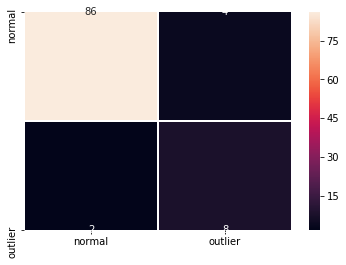

In [9]:
labels = outlier_batch.target_names
cm = confusion_matrix(target, preds)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
sns.heatmap(df_cm, annot=True, cbar=True, linewidths=.5)
plt.show()

Plot scores vs. the outlier threshold:

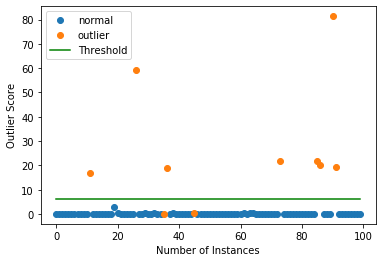

In [10]:
plot_outlier_scores(scores, target, labels, threshold)